<a href="https://colab.research.google.com/github/Chuck2Win/Tutoring_machine-learning/blob/master/Neural_Network_lecture(from_scratch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import IPython 

In [2]:
data=pd.read_csv('https://raw.githubusercontent.com/Chuck2Win/Tutoring_machine-learning/master/data/mnist%20(1).csv',header=None)

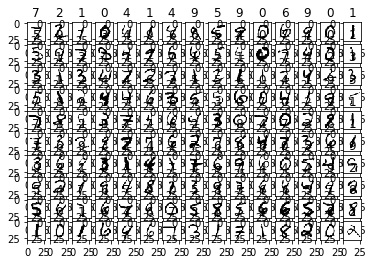

In [21]:
size_row = 28 # height of the image
size_col = 28 # width of the image
num_image = len(data) # 10000
count = 0 # count for the number of images
#
# normalize the values of the input data to be [0, 1]
#
def normalize(data):
    data_normalized = (data - min(data)) / (max(data) - min(data))
    return(data_normalized)
#
# example of distance function between two vectors x and y
#
def distance(x, y):
    d = (x - y) ** 2
    s = np.sum(d)
# r = np.sqrt(s)
    return(s)
#
# make a matrix each column of which represents an images in a vector form
#
list_image = np.empty((size_row * size_col, num_image), dtype=float)
list_label = np.empty(num_image, dtype=int)
for i in range(len(data)):
    data_i=data.loc[i,:]
    label = data_i[0]
    im_vector = data.loc[i,:][1:].to_numpy()
    im_vector = normalize(im_vector)
    list_label[count] = label
    list_image[:, count] = im_vector
    count += 1
#
# plot first 150 images out of 10,000 with their labels
#
f1 = plt.figure(1)
for i in range(150):
    label = list_label[i]
    im_vector = list_image[:, i]
    im_matrix = im_vector.reshape((size_row, size_col))
    plt.subplot(10, 15, i+1)
    plt.title(label)
    plt.imshow(im_matrix, cmap='Greys', interpolation='None')
    frame = plt.gca()

# 0. Optimization

In [38]:
def sigmoid(input):
    return 1/(1+np.exp(-input))

In [27]:
def one_hot_encode(target,k=10):
    # target shape : m
    one_hot_encoded=np.zeros((len(target),k)) # m,k
    for _,i in enumerate(target):
        one_hot_encoded[_,i]=1
    return one_hot_encoded.T # k,m 즉 벡터 꼴로 바꿔준다.

one_hot_encode(np.array([3]),10)

array([[0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [31]:
target=one_hot_encode(np.array(list_label))
print(target)
print(target.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(10, 10000)


In [88]:
# train과 test로 나눈다
train_target=target[:,:6000]
train_list_image=list_image[:,:6000]
test_target=target[:,6000:]
test_list_image=list_image[:,6000:]

In [32]:
# binary cross entropy loss
# broad cast를 활용
def binary_cross_entropy_loss(input,target):
    # input shape : k,m
    # target shape : k,m
    
    '''
    example
    input = [[0.7,0.2 0.1]]
    target = [0,1,0]
    '''
    
    return -((target*np.log((input+1e-7))+(1-target)*np.log((1-input+1e-7)))).mean()

In [23]:
print(list_label)
print(list_image)
print(list_image.shape) # 784,10000 

[7 2 1 ... 4 5 6]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(784, 10000)


https://github.com/Chuck2Win/Tutoring_machine-learning/blob/master/data/%EC%9D%B4%EB%AF%B8%EC%A7%80%202.jpg
<- backpropagation 설명

In [75]:
# hidden layer 1개
# vector 형태
class NeuralNet:
    def __init__(self):
        # layer dims : list 형태 ~ (s0,s1,s2)
        # W  ~ (W1,W2)
        self.W1 = np.random.randn(196,784)
        self.W2 = np.random.randn(49,196)
        self.W3 = np.random.randn(10,49)
        self.b1 = np.zeros(1)
        self.b2 = np.zeros(1)
        self.b3 = np.zeros(1)
        self.x = None
        self.z1 = None
        self.a1 = None
        self.z2 = None
        self.a2 = None
        self.z3 = None
        self.a3 = None
        self.dW1 = None
        self.dW2 = None
        self.dW3 = None
        self.db1 = None
        self.db2 = None
        self.db3 = None
        
    def forward(self,input,target):
        # input shape : 784,m
        # z1,a1 shape : 196,m
        # z2,a2 shape : 49,m
        # z3,a3 shape : 10,m
        self.x = input
        self.z1 = self.W1.dot(self.x)+self.b1
        self.a1 = sigmoid(self.z1)
        self.z2 = self.W2.dot(self.a1)+self.b2
        self.a2 = sigmoid(self.z2)
        self.z3 = self.W3.dot(self.a2)+self.b3
        self.a3 = sigmoid(self.z3)
        self.target = target
        cost = binary_cross_entropy_loss(self.a3,self.target)
        return cost,self.a3
    
    def gradient(self):
        # target shape : s2,1 <- one hot encoded
        sigma = (self.a3 - self.target) * sigmoid(self.z3)*(1-sigmoid(self.z3))
        self.dW3 = sigma.dot(self.a2.T) 
        self.db3 = sigma.sum()
        sigma = (sigma.T).dot(model.W3).T * sigmoid(self.z2)*(1-sigmoid(self.z2))
        self.dW2 = sigma.dot(self.a1.T)
        self.db2 = sigma.sum()
        sigma = (sigma.T).dot(self.W2).T * sigmoid(self.z1)*(1-sigmoid(self.z1))
        self.dW1 = sigma.dot(self.x.T)
        self.db1 = sigma.sum()        

# Train

In [90]:
# train
lr=0.0001
cost=[]
ACC=[]
test_cost=[]
test_ACC=[]
epochs=5000
model=NeuralNet()
for epoch in range(1,epochs+1):
    total_loss=0
    total_acc=0
    test_loss,test_predict=model.forward(test_list_image,test_target)
    test_cost.append(test_loss)
    test_acc=(test_predict.argmax(0)==test_target.argmax(0)).mean()
    test_ACC.append(test_acc)
    loss,predict=model.forward(train_list_image,train_target)
    model.gradient()
    model.W3=model.W3-lr*model.dW3
    model.W2=model.W2-lr*model.dW2
    model.W1=model.W1-lr*model.dW1
    model.b3=model.b2-lr*model.db2
    model.b2=model.b2-lr*model.db2
    model.b1=model.b1-lr*model.db1
    acc=(predict.argmax(0)==train_target.argmax(0)).mean()
    cost.append(loss)
    ACC.append(acc)
    if epoch>0 and epoch%1000==0:
        print('-'*100)
        print('| epoch %d | cost %.2f | acc %.2f |'%(epoch,loss,acc))
        print('-'*100)

----------------------------------------------------------------------------------------------------
| epoch 1000 | cost 0.28 | acc 0.57 |
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
| epoch 2000 | cost 0.18 | acc 0.74 |
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
| epoch 3000 | cost 0.15 | acc 0.78 |
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
| epoch 4000 | cost 0.09 | acc 0.87 |
----------------------------------------------------------------------------------------------------
----------------------------------------

KeyboardInterrupt: ignored

# 1. Plot the loss curve


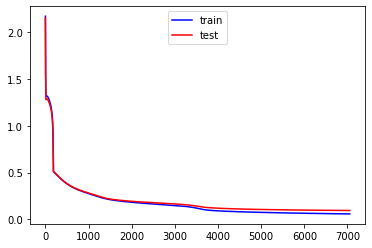

In [91]:
plt.plot(cost,'b',label='train')
plt.plot(test_cost,'r',label='test')
plt.legend(loc=9)
plt.show()

# 2. Plot the accuracy curve


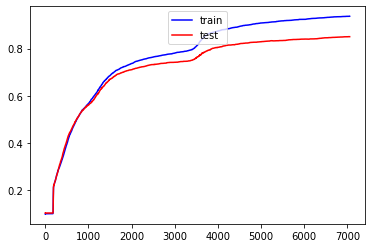

In [92]:
plt.plot(ACC,'b',label='train')
plt.plot(test_ACC,'r',label='test')
plt.legend(loc=9)
plt.show()

# 3. Plot the accuracy value

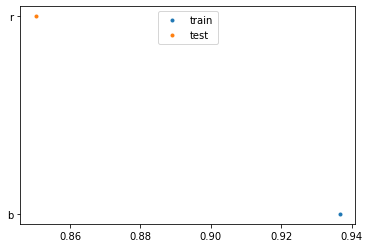

In [96]:
plt.plot(ACC[-1],'b','.',label='train')
plt.plot(test_ACC[-1],'r','.',label='test')
plt.legend(loc=9)
plt.show()

# 4. Plot the classification example

In [125]:
cost,predict=model.forward(test_list_image,test_target)
# correctly classified
correct_im=test_list_image[:,(predict.argmax(0)==test_target.argmax(0))]
correct_label=test_target[:,(predict.argmax(0)==test_target.argmax(0))].argmax(0)
# misclassified
wrong_im=test_list_image[:,(predict.argmax(0)!=test_target.argmax(0))]
wrong_label=test_target[:,(predict.argmax(0)!=test_target.argmax(0))].argmax(0)
wrong_label_predicted=predict[:,(predict.argmax(0)!=test_target.argmax(0))].argmax(0)

In [126]:
wrong_label_predicted

array([5, 8, 3, 2, 9, 0, 7, 9, 8, 8, 5, 5, 5, 6, 0, 8, 8, 0, 0, 6, 4, 8,
       0, 2, 8, 0, 4, 5, 5, 4, 3, 2, 6, 3, 2, 0, 8, 4, 2, 6, 2, 4, 5, 2,
       0, 5, 4, 5, 4, 0, 8, 2, 4, 2, 1, 5, 7, 5, 6, 8, 1, 1, 5, 9, 6, 8,
       5, 6, 9, 0, 7, 8, 7, 5, 5, 5, 4, 7, 9, 9, 4, 2, 5, 9, 8, 7, 5, 7,
       2, 2, 0, 5, 2, 2, 2, 6, 6, 9, 3, 1, 2, 7, 2, 6, 4, 4, 2, 6, 9, 8,
       0, 4, 1, 6, 0, 6, 8, 4, 4, 7, 3, 2, 4, 6, 4, 6, 6, 7, 7, 8, 6, 1,
       7, 9, 6, 9, 8, 8, 4, 3, 7, 1, 2, 4, 8, 5, 4, 5, 2, 5, 7, 5, 9, 7,
       2, 9, 5, 4, 0, 0, 4, 2, 0, 0, 2, 7, 7, 2, 4, 6, 9, 2, 4, 9, 2, 8,
       8, 4, 2, 7, 7, 0, 7, 2, 0, 3, 5, 3, 3, 7, 7, 5, 9, 8, 2, 5, 6, 6,
       2, 8, 9, 2, 2, 2, 2, 1, 0, 8, 3, 6, 8, 8, 2, 2, 9, 5, 4, 1, 4, 8,
       2, 7, 5, 2, 7, 5, 8, 8, 8, 6, 4, 9, 0, 5, 9, 6, 6, 6, 4, 4, 8, 9,
       0, 5, 5, 5, 4, 3, 7, 8, 6, 6, 8, 2, 8, 8, 1, 2, 2, 8, 2, 2, 9, 6,
       2, 9, 4, 0, 2, 4, 8, 8, 8, 2, 4, 2, 4, 9, 4, 9, 0, 9, 2, 9, 2, 4,
       2, 2, 1, 4, 2, 9, 4, 8, 4, 2, 8, 0, 0, 4, 9,

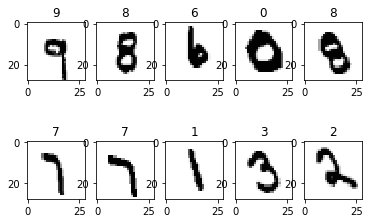

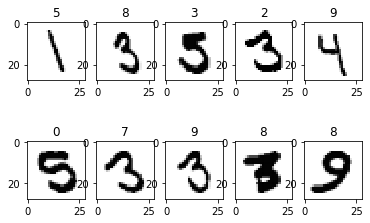

In [127]:
# correct
f1 = plt.figure()
for i in range(10):
    label = correct_label[i]
    im_vector = correct_im[:, i]
    im_matrix = im_vector.reshape((size_row, size_col))
    plt.subplot(2, 5, i+1)
    plt.title(label)
    plt.imshow(im_matrix, cmap='Greys', interpolation='None')
    frame = plt.gca()
plt.show()

# wrong
f1 = plt.figure()
for i in range(10):
    label = wrong_label_predicted[i]
    im_vector = wrong_im[:, i]
    im_matrix = im_vector.reshape((size_row, size_col))
    plt.subplot(2, 5, i+1)
    plt.title(label)
    plt.imshow(im_matrix, cmap='Greys', interpolation='None')
    frame = plt.gca()
plt.show()